Segmentation RFM (Récence, Fréquence, Valeur Monétaire), nous devons d'abord calculer les métriques RFM pour chaque utilisateur, puis les classer en segments.

### Étapes pour appliquer la méthode RFM :
1. **Récence (Recency)** : Nombre de jours depuis la dernière interaction ou achat.
2. **Fréquence (Frequency)** : Nombre de fois qu'un utilisateur a interagi ou acheté.
3. **Valeur Monétaire (Monetary Value)** : Montant total dépensé par l'utilisateur.

### Calcul des Scores RFM :
1. **Récence** : Utiliser la colonne `days_since_last_purchase`.
2. **Fréquence** : Utiliser les colonnes de fréquence des interactions (`number_of_sessions_2m`, `number_of_sessions_5m`, etc.).
3. **Valeur Monétaire** : Utiliser `total_purchase_value`.


In [19]:
import pyarrow.parquet as pq
import pyarrow as pa
import pandas as pd
import requests
import io
from urllib.parse import urljoin

In [20]:
# URL directe vers le fichier Parquet sur GitHub
url = "https://github.com/EricIrjam/e-amazing/raw/main/data/user_stats_df_output.parquet"

In [21]:
# Fonction pour récupérer et lire tous les fichiers .parquet dans le répertoire
def read_parquet_files(base_url):
    # Les fichiers que nous devons récupérer
    file_names = [
        f"part-0000{i}-9b319896-debc-49c4-b0a7-fbbd59863d51-c000.snappy.parquet" for i in range(5)
    ]

    # Lire et combiner tous les fichiers Parquet en un seul DataFrame
    tables = []
    for file_name in file_names:
        file_url = urljoin(base_url, file_name)
        response = requests.get(file_url)
        response.raise_for_status()

        # Lire le fichier Parquet
        table = pq.read_table(io.BytesIO(response.content))
        tables.append(table)

    # Combiner toutes les tables en une seule
    combined_table = pa.concat_tables(tables)
    return combined_table.to_pandas()

In [22]:
df = read_parquet_files(base_url)

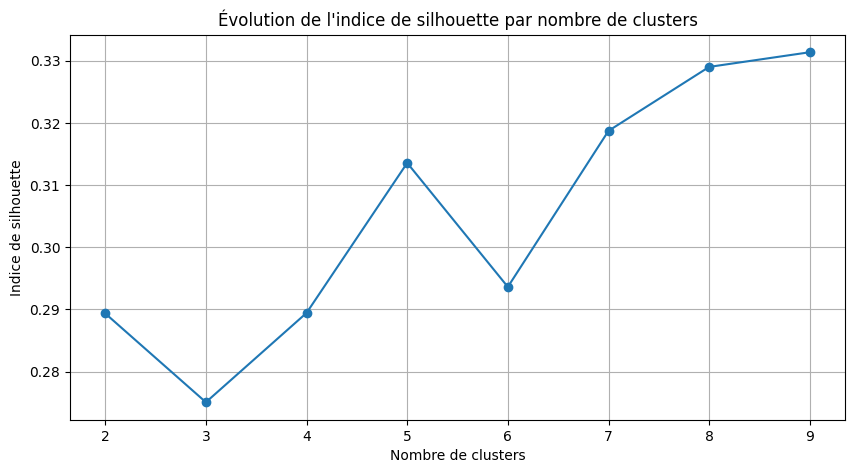

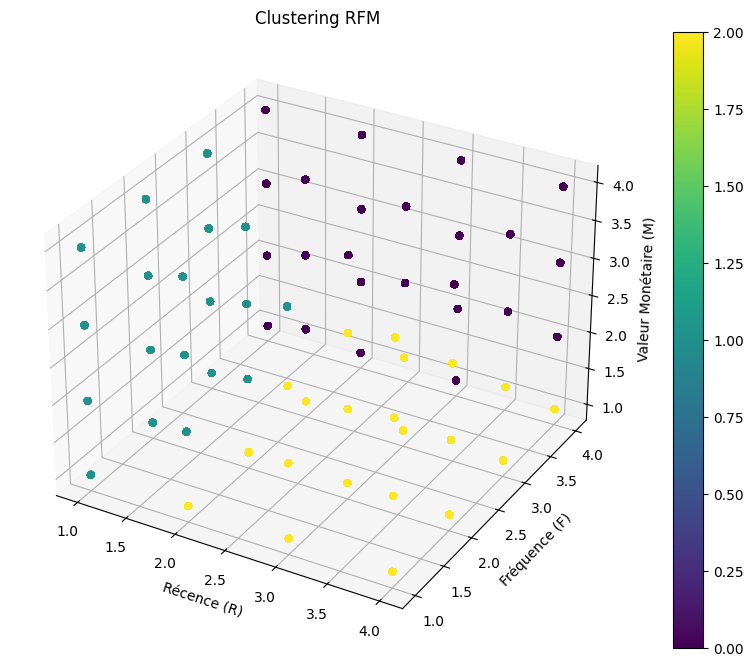

In [24]:

import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D

# Calcul des scores RFM
# Recency : on utilise la colonne 'days_since_last_purchase' (moins c'est élevé, mieux c'est)
df['R_Score'] = pd.qcut(df['days_since_last_purchase'], q=4, labels=[4, 3, 2, 1])

# Frequency : on utilise les sessions des 7 derniers mois (plus c'est élevé, mieux c'est)
df['F_Score'] = pd.qcut(df['number_of_sessions_7m'], q=4, labels=[1, 2, 3, 4])

# Monetary Value : on utilise la colonne 'total_purchase_value' (plus c'est élevé, mieux c'est)
df['M_Score'] = pd.qcut(df['total_purchase_value'], q=4, labels=[1, 2, 3, 4])

# Préparation des données pour le clustering
X = df[['R_Score', 'F_Score', 'M_Score']].astype(int)

# Calcul de l'indice de silhouette pour différents nombres de clusters
silhouette_scores = []
range_n_clusters = range(2, 10)

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Graphique de l'évolution de l'indice de silhouette
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title("Évolution de l'indice de silhouette par nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Indice de silhouette")
plt.grid(True)
plt.show()

# Clustering avec le nombre optimal de clusters trouvé (exemple : 3 clusters)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Graphique 3D du clustering
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(df['R_Score'], df['F_Score'], df['M_Score'], c=df['cluster'], cmap='viridis')

# Titres et labels
ax.set_title('Clustering RFM')
ax.set_xlabel('Récence (R)')
ax.set_ylabel('Fréquence (F)')
ax.set_zlabel('Valeur Monétaire (M)')
plt.colorbar(scatter)
plt.show()


### Explications : **A voir pour l'interprétation :**
- **Recency Score (`R_Score`)** : Les utilisateurs sont divisés en 4 groupes selon la récence de leur dernière interaction. Le groupe avec les valeurs les plus faibles (récence faible) reçoit le score le plus élevé.
- **Frequency Score (`F_Score`)** : Les utilisateurs sont segmentés selon le nombre de sessions sur les 7 derniers mois.
- **Monetary Score (`M_Score`)** : Les utilisateurs sont classés selon la valeur totale des achats.
- **Segmentation (`RFM_Segment`)** : Les scores combinés sont utilisés pour segmenter les utilisateurs en groupes comme "Champions", "Loyal", "Potentiels", etc. `en fonction du nombre de clusters apparent.`